### Exercise 1

In [3]:
#project 2 - Computer Intense Methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

np.random.seed(123)


tau = pd.read_csv('coal-mine.csv', header = None).to_numpy().flatten()
t1 =  1851
tlast =  1963

In [5]:
def posterior(t, lamb):
    diff = np.diff(t)[1:]
    return np.prod(diff) * np.exp(-np.sum(lamb * diff))

#tau
#idx = np.searchsorted(tau, t)
#t

In [6]:
def hybridMCMC(d,v,rho):   
    # fixed v and sample initial theta
    theta = np.random.gamma(2, 1/v)

    # fixed d and sample initial t's
    t = np.sort(np.random.uniform(t1, tlast, d)) # initial t's uniformly distributed between [t1, tlast]
    t = np.concatenate( (np.array([t1]), t, np.array([tlast])))

    N = 10000
    probabs = []
    lamb_store = []
    theta_store = []
    t_store = []

    for i in range(N):
        # sample lambda
        ## use np.searchsorted to find n_i(tau) = number of disasters in [t_i, t_i+1)
        idx = np.searchsorted(tau, t)
        n = np.diff(idx)
        ## we need to sample each element lambda_i separately (where i = 1, ..., d)
        lamb = []
        for j in range(d):
            lamb.append(np.random.gamma(n[j]+2, 1/(theta + (t[j+1]-t[j]))))
        lamb = np.array(lamb)
        #store the lamb values
        lamb_store.append(lamb)
        
        # sample theta
        theta = np.random.gamma(2*d+2, 1/(v + np.sum(lamb)))
        theta_store.append(theta)
        
        # MH step for t
        ## choose candidate
        t_star = t.copy()
        for j in range(1, d+1):
            R = rho*(t[j+1] - t[j-1])
            eps = np.random.uniform(-R, R) # different epsilon for every t_i ??
            if t_star[j-1] < t[j] + eps < t_star[j+1]:
                t_star[j] = t[j] + eps

        ## accept or reject
        acceptance_probab = min(1, posterior(t_star, lamb)/posterior(t, lamb))
        probabs.append(acceptance_probab)
        u = np.random.uniform()
        if u <= acceptance_probab:
            # accept candidate
            t = t_star
            # else t stays the same
        t_store.append(t)
    return(lamb_store,theta_store,t_store,probabs)

#### sensitivity when changing d={1,2,3,4}

In [7]:
values_d=[]
for d in range(1,5):
     val = hybridMCMC(d,v=2,rho = 0.5)
     values_d.append(val) 

#### trace plot theta

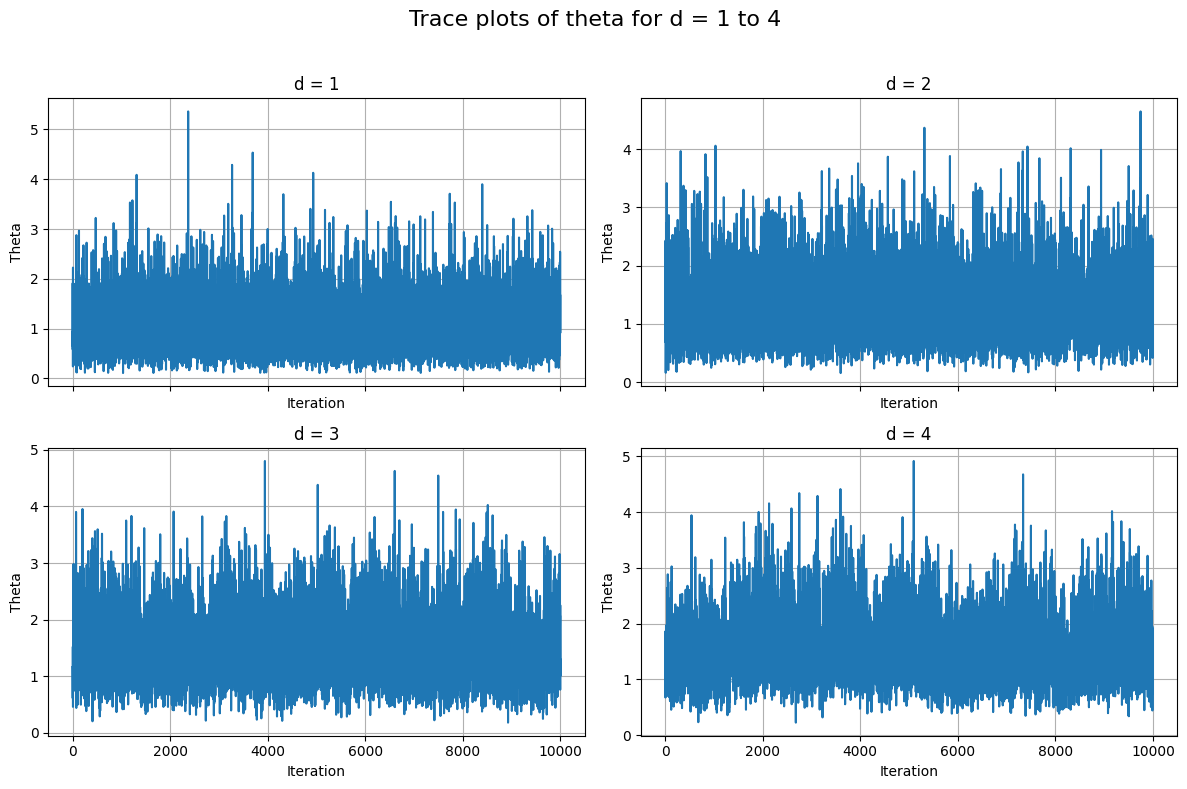

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten() 

for d in range(4):
    theta_store = values_d[d][1]
    ax = axes[d]
    ax.plot(theta_store)
    ax.set_title(f"d = {d+1}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Theta")
    ax.grid(True)

fig.suptitle("Trace plots of theta for d = 1 to 4", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### trace plot lambda

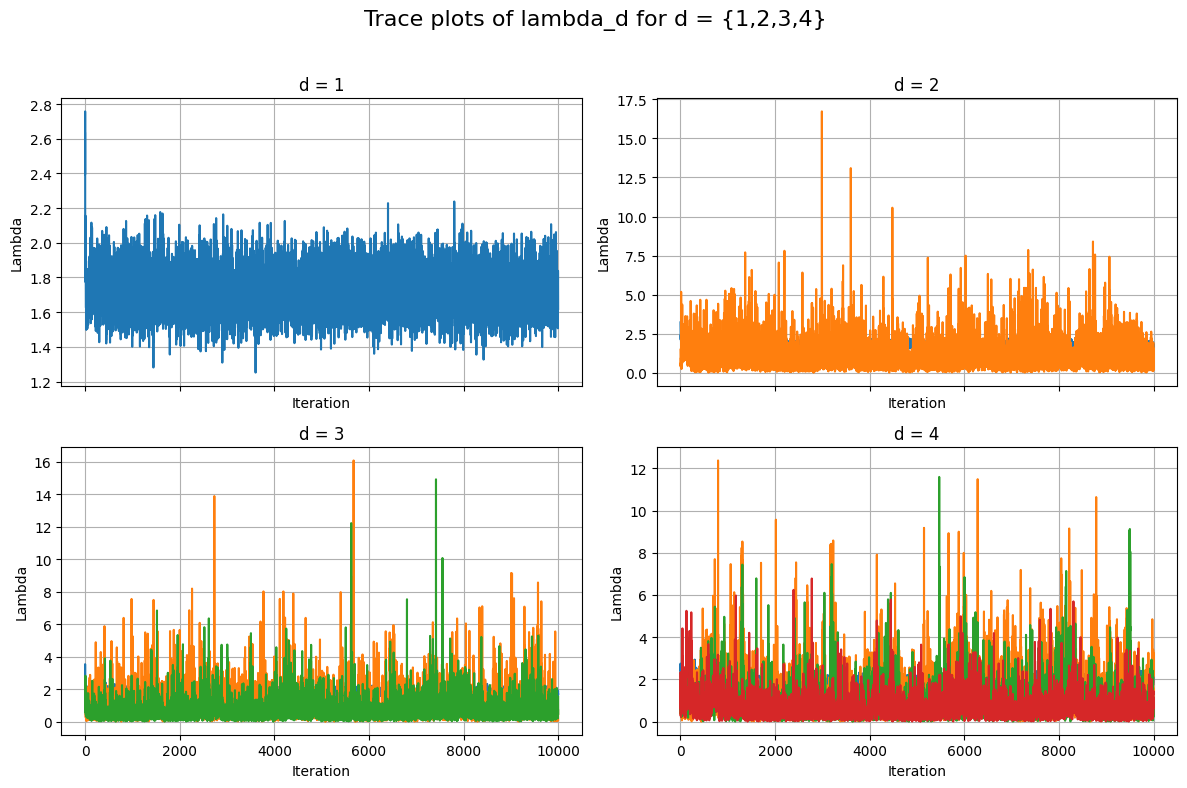

In [9]:
#for d=4 all the lambdas for all the breakpoints different
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for d in range(4):
    lamb_store = np.array(values_d[d][0])
    ax = axes[d]
    ax.plot(lamb_store)
    #ax.plot(lamb_store[:,d])
    ax.set_title(f"d = {d+1}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Lambda")
    ax.grid(True)

#i dont know if we always plot lambda_d for each d or if lambda_i, i={1,...,4} for all differnt d???
fig.suptitle("Trace plots of lambda_d for d = {1,2,3,4}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

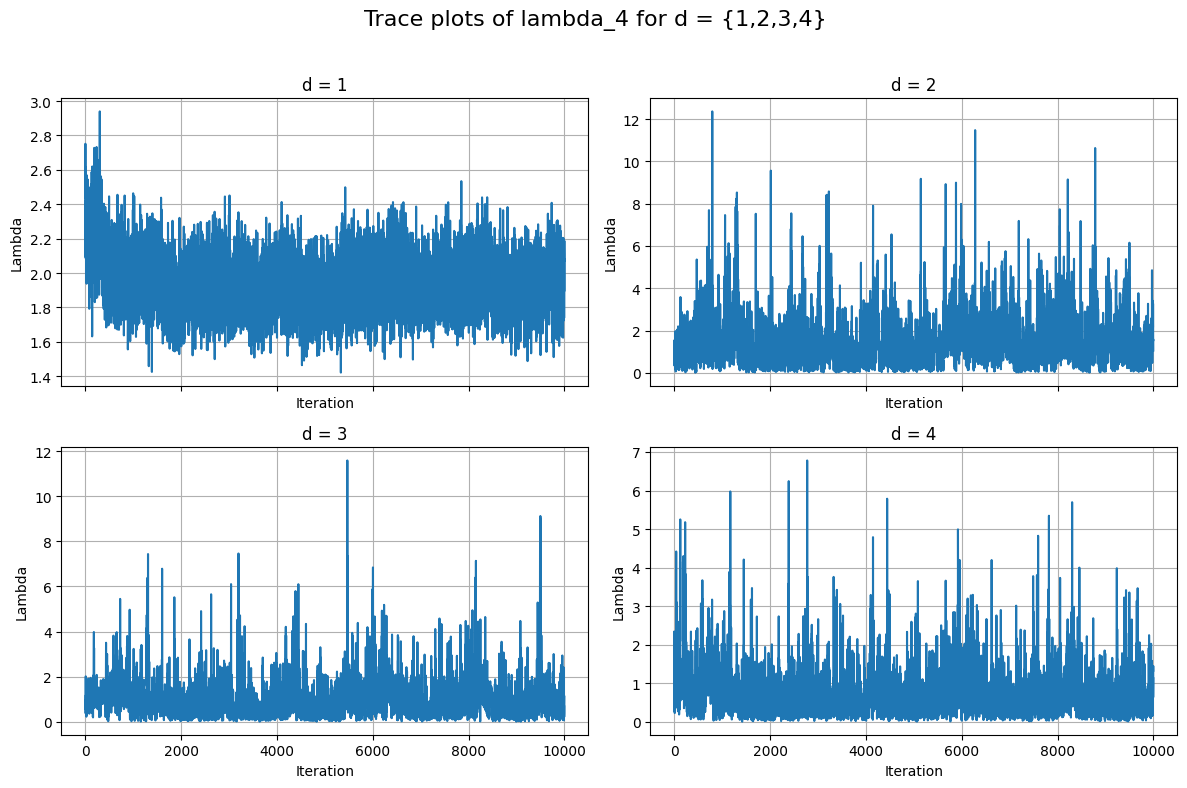

In [10]:
# trying to just plot all d=4, all lambda
#so plotting all the breakpoints for d=4 
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for d in range(4):
    lamb_store = np.array(values_d[3][0])
    ax = axes[d]
    ax.plot(lamb_store[:,d])
    #ax.plot(lamb_store[:,d])
    ax.set_title(f"d = {d+1}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Lambda")
    ax.grid(True)

#i dont know if we always plot lambda_d for each d or if lambda_i, i={1,...,4} for all differnt d???
fig.suptitle("Trace plots of lambda_4 for d = {1,2,3,4}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

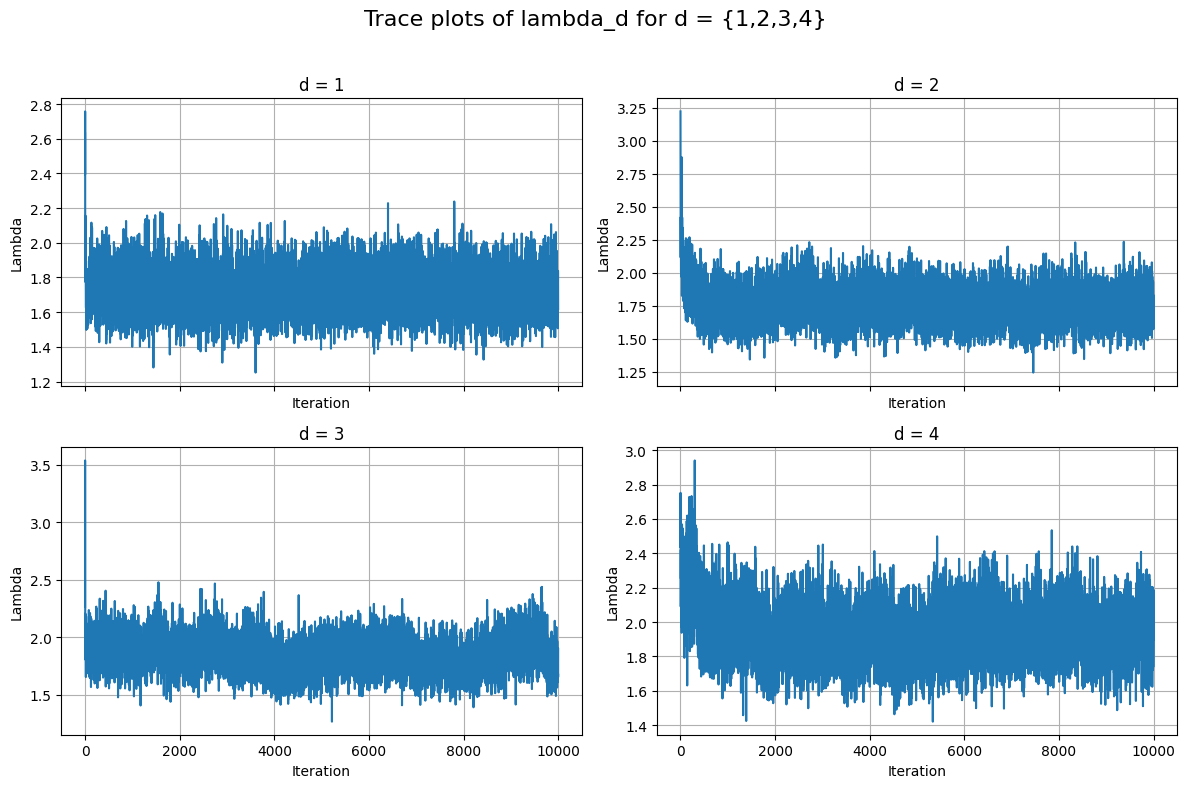

In [11]:
#now plotting always the lamda_d for d
#so for d=3 the third lambda, for d=2 the second lambda
#so just plotting the d-th lambda for d={1,2,3,4}
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for d in range(4):
    lamb_store = np.array(values_d[d][0])
    ax = axes[d]
    ax.plot(lamb_store[:,0])
    ax.set_title(f"d = {d+1}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Lambda")
    ax.grid(True)

#i dont know if we always plot lambda_d for each d or if lambda_i, i={1,...,4} for all differnt d???
fig.suptitle("Trace plots of lambda_d for d = {1,2,3,4}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### density

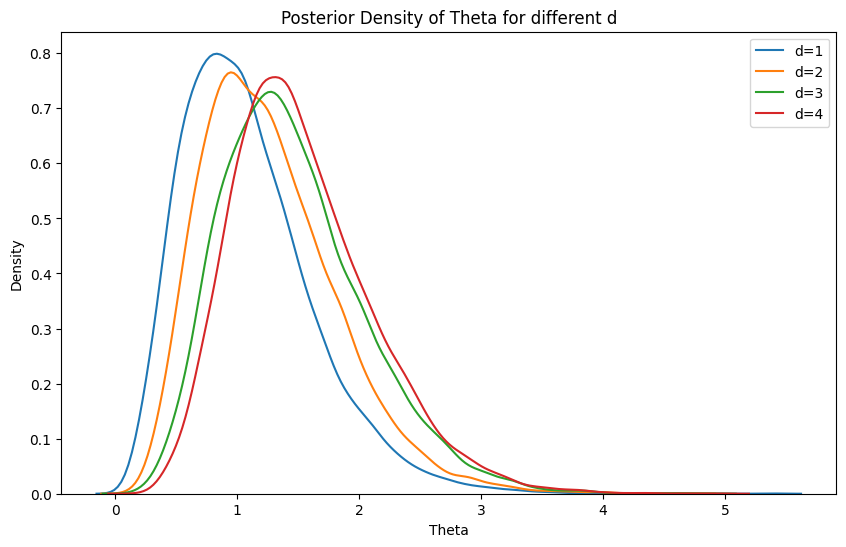

In [12]:
#density of posterior after burn-in
plt.figure(figsize=(10, 6))
for d in range(4):
    theta_chain = values_d[d][1][1000:]  #after burn-in
    sns.kdeplot(theta_chain, label=f'd={d+1}',fill=False)
plt.title("Posterior Density of Theta for different d")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

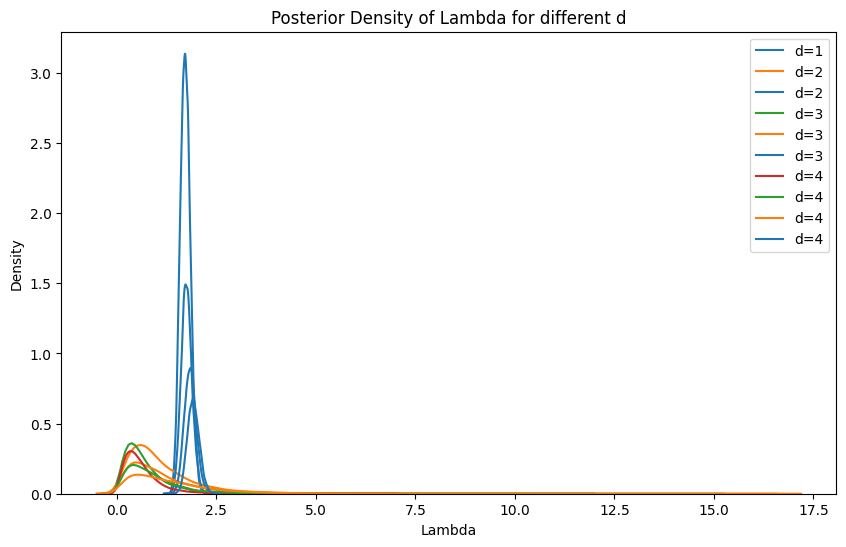

In [14]:
#density of posterior after burn-in
plt.figure(figsize=(10, 6))
for d in range(4):
    lambda_chain = np.array(values_d[d][0])[1000:]  #after burn-in
    sns.kdeplot(lambda_chain, label=f'd={d+1}',fill=False)
plt.title("Posterior Density of Lambda for different d")
plt.xlabel("Lambda")
plt.ylabel("Density")
plt.legend()
plt.show()

/var/folders/hk/jg1h1p2564j8w6vhgd8dx26r0000gn/T/ipykernel_37922/3127239479.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(lambda_chain, label=f'd={d+1}',fill=False)
/var/folders/hk/jg1h1p2564j8w6vhgd8dx26r0000gn/T/ipykernel_37922/3127239479.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(lambda_chain, label=f'd={d+1}',fill=False)
/var/folders/hk/jg1h1p2564j8w6vhgd8dx26r0000gn/T/ipykernel_37922/3127239479.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(lambda_chain, label=f'd={d+1}',fill=False)
/var/folders/hk/jg1h1p2564j8w6vhgd8dx26r0000gn/T/ipykernel_37922/3127239479.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(lambda_chain, label=f'd

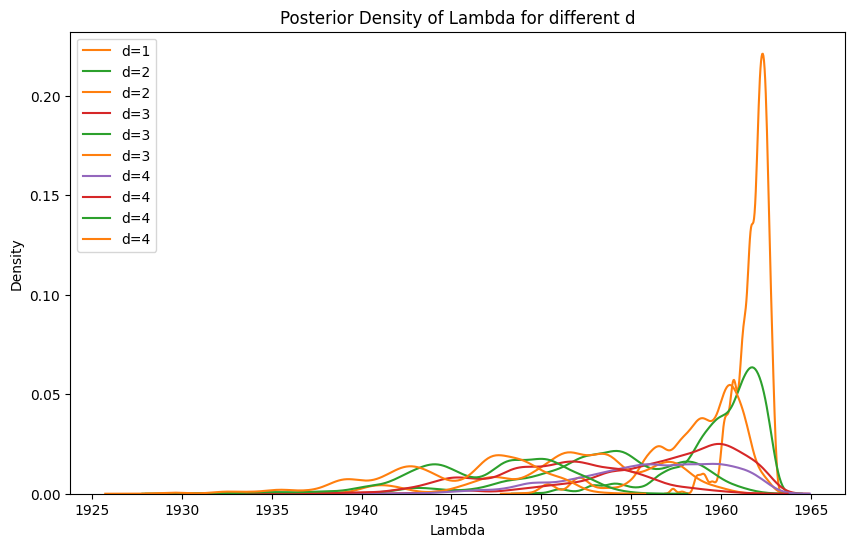

In [15]:
#density of posterior after burn-in
plt.figure(figsize=(10, 6))
for d in range(4):
    lambda_chain = np.array(values_d[d][2])[1000:]  #after burn-in
    sns.kdeplot(lambda_chain, label=f'd={d+1}',fill=False)
plt.title("Posterior Density of Lambda for different d")
plt.xlabel("Lambda")
plt.ylabel("Density")
plt.legend()
plt.show()

In [61]:
#different acceptance rates
acc_rate =[]

for d in range(4):
    rate =np.mean(values_d[d][3])
    acc_rate.append(rate)
print(np.array(acc_rate))

[0.50635818 0.38176812 0.3185236  0.29599506]


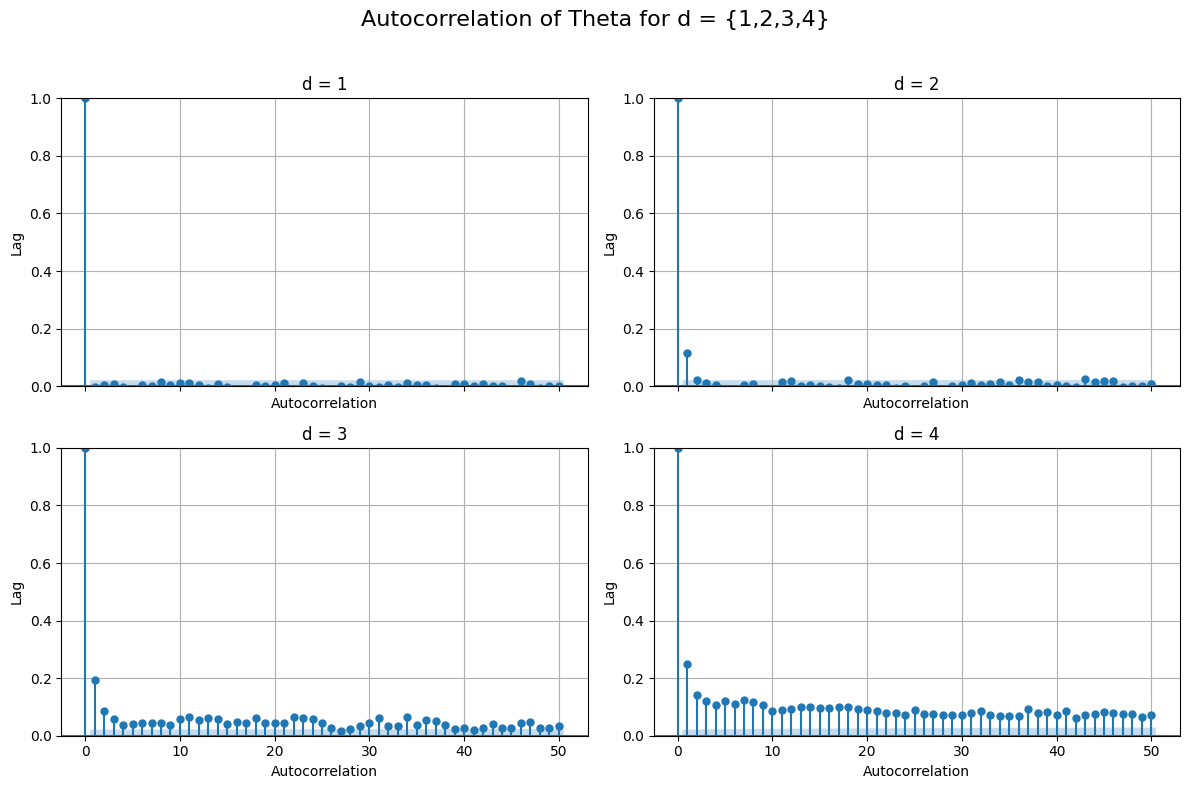

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for d in range(4):
    theta_store = np.array(values_d[d][1])
    ax = axes[d]
    sm.graphics.tsa.plot_acf(theta_store[1000:], lags=50, ax=ax, title=f"d = {d+1}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Autocorrelation")
    ax.set_ylabel("Lag")
    ax.grid(True)

fig.suptitle("Autocorrelation of Theta for d = {1,2,3,4}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### sensitivity for different v

In [77]:
values_v=[]
for diff_v in [0.5, 1, 2, 3]:
     val = hybridMCMC(d=2, v=diff_v, rho = 0.5)
     values_v.append(val)

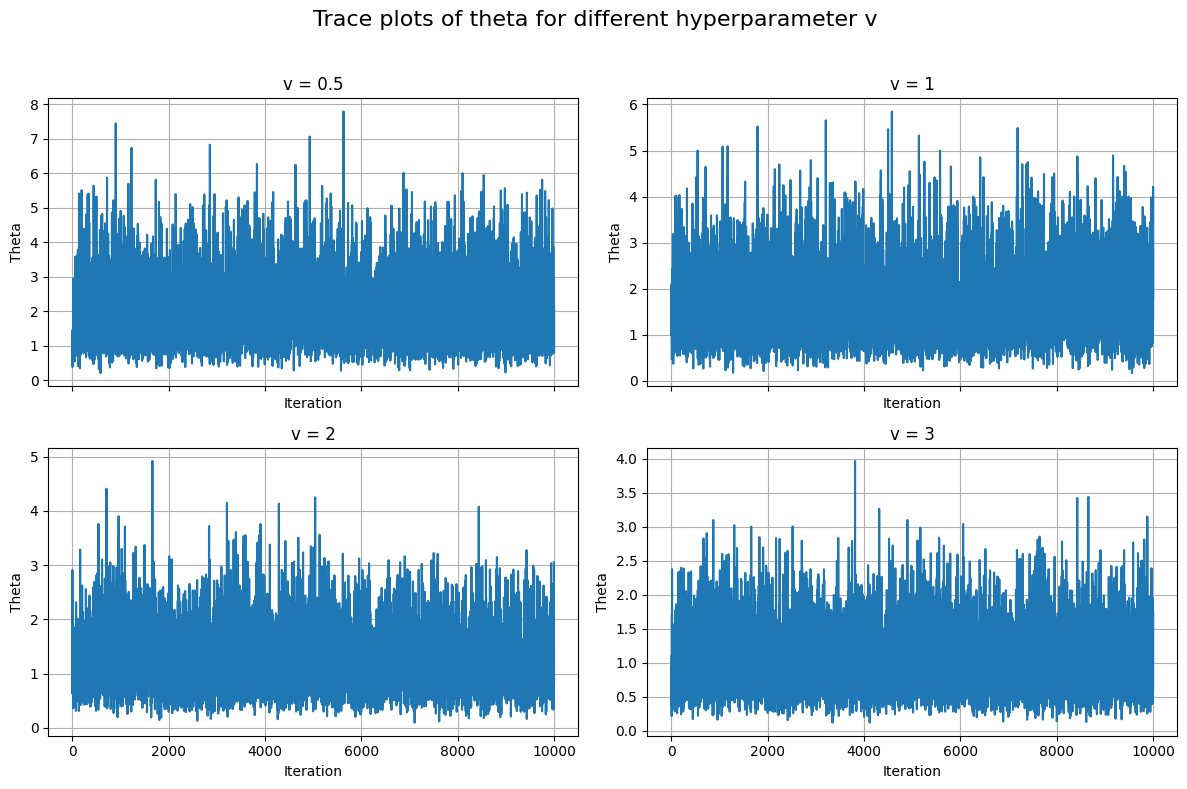

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()
v_vec = [0.5, 1, 2, 3]

for v in range(4):
    theta_store = values_v[v][1]
    ax = axes[v]
    ax.plot(theta_store)
    ax.set_title(f"v = {v_vec[v]}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Theta")
    ax.grid(True)

fig.suptitle("Trace plots of theta for different hyperparameter v", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

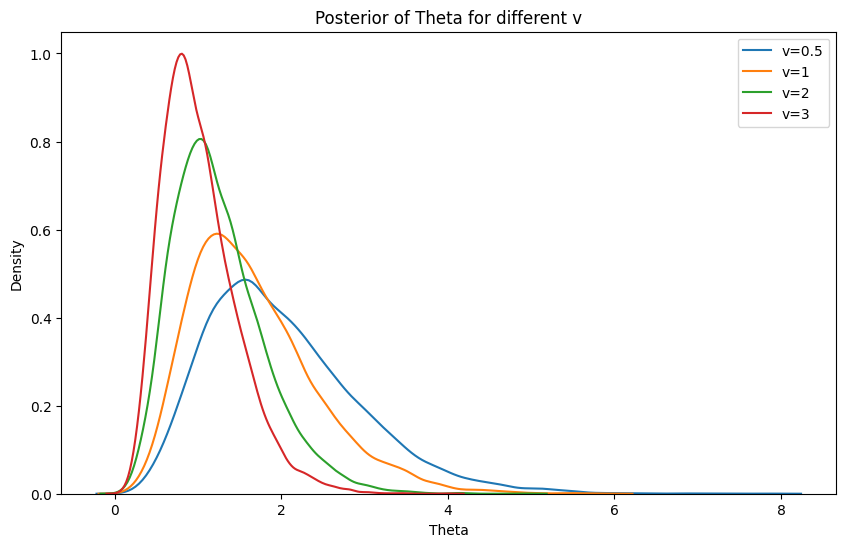

In [82]:
plt.figure(figsize=(10, 6))
for v in range(4):
    theta_chain = values_v[v][1][1000:]  #after burn-in
    sns.kdeplot(theta_chain, label=f'v={v_vec[v]}',fill=False)
plt.title("Posterior of Theta for different v")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

In [84]:
#different acceptance rates
acc_rate =[]

for d in range(4):
    rate =np.mean(values_v[d][3])
    acc_rate.append(rate)
print(np.array(acc_rate))

[0.38423944 0.3840724  0.40174363 0.39151831]


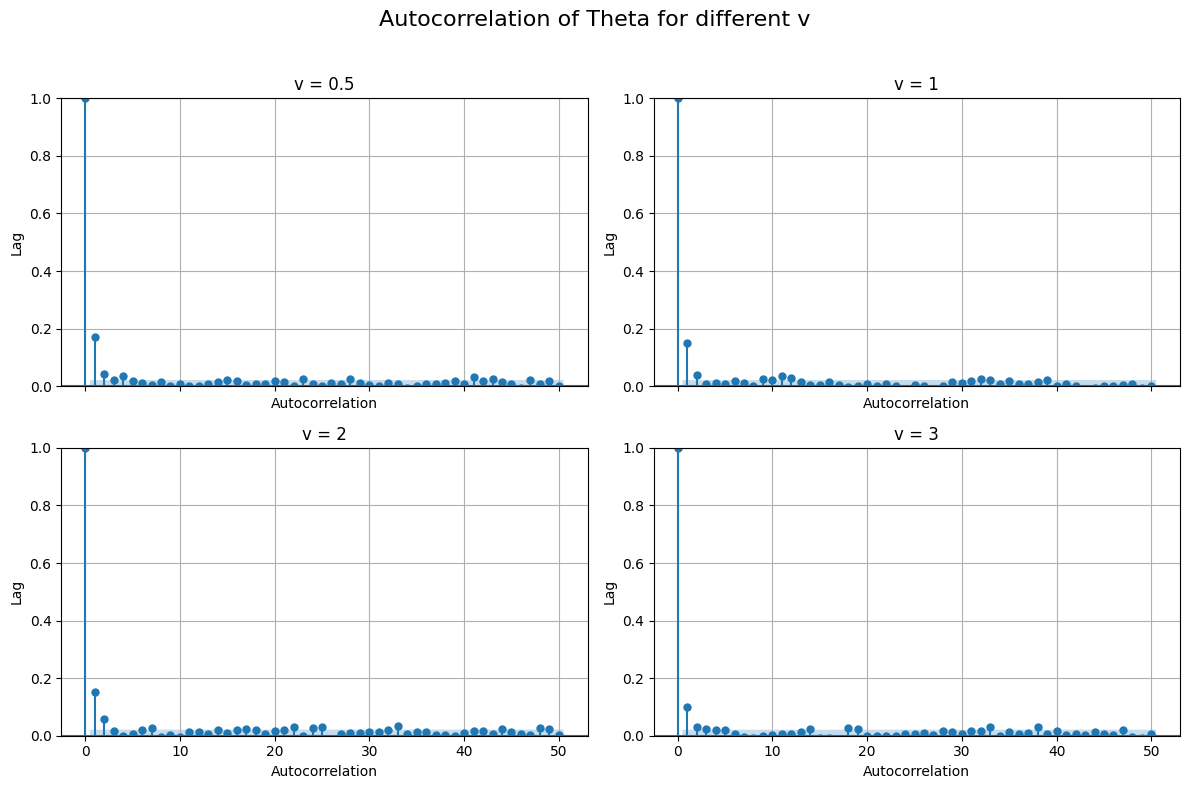

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for v in range(4):
    theta_store = np.array(values_v[v][1])
    ax = axes[v]
    sm.graphics.tsa.plot_acf(theta_store[1000:], lags=50, ax=ax, title=f"v = {v_vec[v]}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Autocorrelation")
    ax.set_ylabel("Lag")
    ax.grid(True)

fig.suptitle("Autocorrelation of Theta for different v", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

#### different rho

In [85]:
values_rho=[]
for diff_rho in [0.5, 1, 2, 3]:
     val = hybridMCMC(d=2, v=2, rho = diff_rho)
     values_rho.append(val)

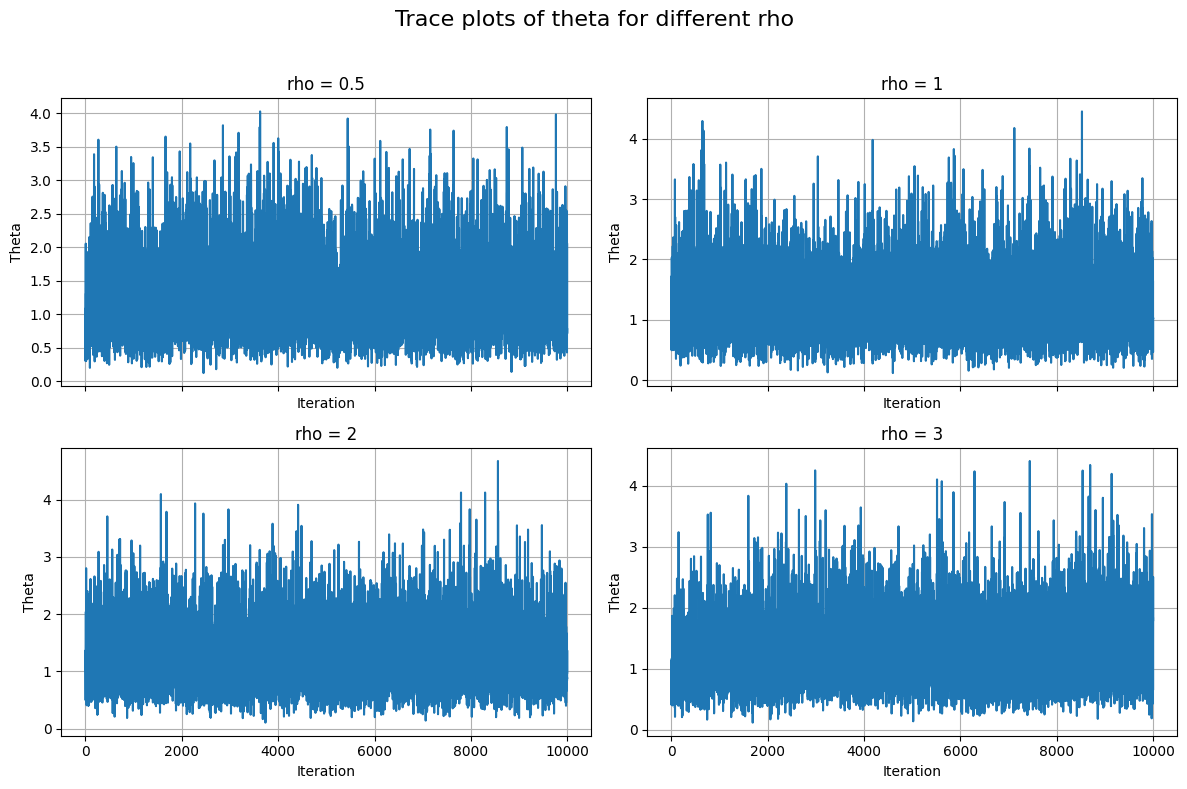

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()
rho_vec = [0.5, 1, 2, 3]

for rho in range(4):
    theta_store = values_rho[rho][1]
    ax = axes[rho]
    ax.plot(theta_store)
    ax.set_title(f"rho = {rho_vec[rho]}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Theta")
    ax.grid(True)

fig.suptitle("Trace plots of theta for different rho", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

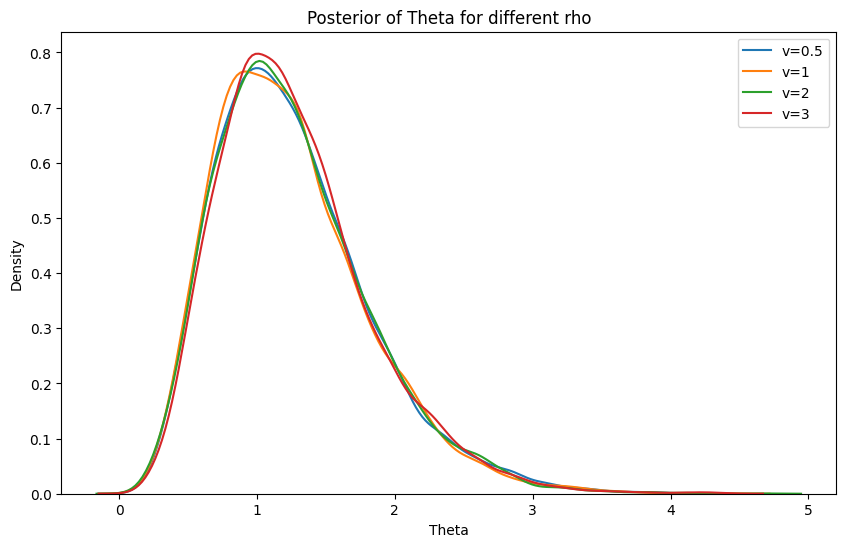

In [89]:
plt.figure(figsize=(10, 6))
for rho in range(4):
    theta_chain = values_rho[rho][1][1000:]  #after burn-in
    sns.kdeplot(theta_chain, label=f'v={rho_vec[rho]}',fill=False)
plt.title("Posterior of Theta for different rho")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.legend()
plt.show()

In [90]:
#different acceptance rates
acc_rate =[]

for rho in range(4):
    rate =np.mean(values_rho[rho][3])
    acc_rate.append(rate)
print(np.array(acc_rate))

[0.39237971 0.43536584 0.69572706 0.77213551]


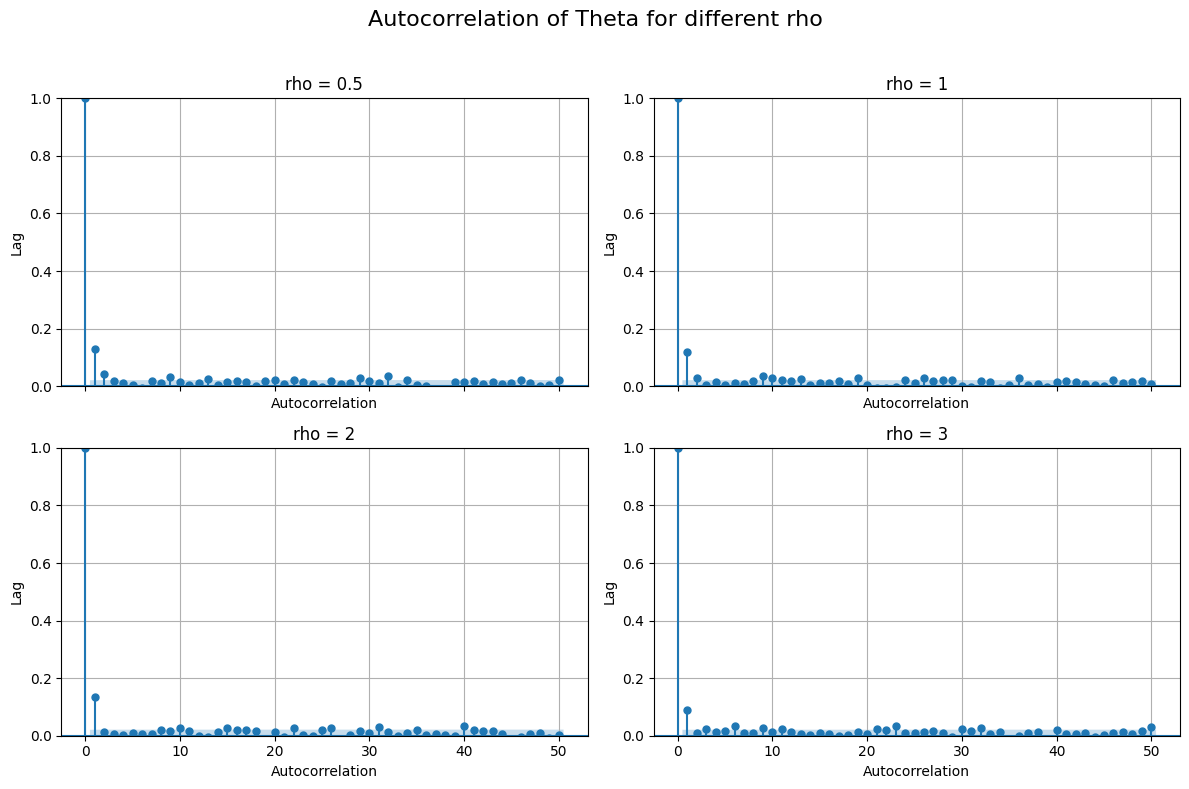

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for rho in range(4):
    theta_store = np.array(values_rho[rho][1])
    ax = axes[rho]
    sm.graphics.tsa.plot_acf(theta_store[1000:], lags=50, ax=ax, title=f"rho = {rho_vec[rho]}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Autocorrelation")
    ax.set_ylabel("Lag")
    ax.grid(True)

fig.suptitle("Autocorrelation of Theta for different rho", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()